# Подготовка данных

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json

In [2]:
url = 'https://www.moscowmap.ru/metro.html#stations'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

In [3]:
url = f'https://www.moscowmap.ru/metro/biryulyovskaya-linija/biryulyovo.html'
response = requests.get(url)
s = BeautifulSoup(response.text, 'html.parser')

In [4]:
stations = soup.find_all('a', class_='listingMetrost_st')

stations_data = []

for station in stations:
    station_name = station.find('span', class_='name').text.strip()
    station_url = station.find('span', class_='pageLink').get('data-href')
    station_num = int(station.find('span', class_='num').text.strip().split('.')[0])
    station_line = station_url.split('/')[2]
    stations_data.append({'station_name': station_name,
                          'station_line': station_line,
                          'station_num': station_num,
                          'station_url': station_url})

print(len(stations_data))

473


In [5]:
stations_data[0]

{'station_name': 'Бульвар Рокоссовского',
 'station_line': 'sokolnicheskaya-linija',
 'station_num': 1,
 'station_url': '/metro/sokolnicheskaya-linija/bulvar-rokossovskogo.html'}

In [6]:
for i, station in enumerate(stations_data):
  url = f'https://www.moscowmap.ru{station["station_url"]}'
  response = requests.get(url)
  s = BeautifulSoup(response.text, 'html.parser')

  header = s.find('h2', class_='t-head', string='О станции')
  if header:
      text_div = header.find_next('div', class_='t-text-simple')
      if text_div:

        transitions = []
        for p in text_div.find_all('p'):
          if p.text.startswith('Переход на станцию'):
            links = p.find_all('a')
            transition_data = {
                'station_name': links[0].text.strip(),
                'station_line': links[1].get('href', '').split('/')[2].split('.')[0],
                'station_url': links[0].get('href', '')
            }
            transitions.append(transition_data)

  stations_data[i]['transitions'] = transitions

In [7]:
stations_data[0]

{'station_name': 'Бульвар Рокоссовского',
 'station_line': 'sokolnicheskaya-linija',
 'station_num': 1,
 'station_url': '/metro/sokolnicheskaya-linija/bulvar-rokossovskogo.html',
 'transitions': [{'station_name': 'Бульвар Рокоссовского',
   'station_line': 'mck',
   'station_url': '/metro/mck/bulvar-rokossovskogo.html'}]}

In [8]:
for i, station in enumerate(stations_data):
  url = f'https://www.moscowmap.ru{station["station_url"]}'
  response = requests.get(url)
  s = BeautifulSoup(response.text, 'html.parser')

  stations_data[i]['in_process'] = 0
  if 'Станция в процессе строительства.' in str(s):
    stations_data[i]['in_process'] = 1
    print(station['station_name'])

Гольяново
Достоевская
Дмитровская
Петровско-Разумовская
Малино
Рижская
Беговая
Станколит
Рижская
ЗИЛ
Крымская
Академическая
Вавиловская
Ильинская
Рублёво-Архангельское
Липовая Роща
Строгино
Серебряный Бор
Бульвар Генерала Карбышева
Народное Ополчение
Звенигородская
ЗИЛ
Кленовый Бульвар
Курьяново
Москворечье
Кавказский бульвар
Каспийская
Липецкая
Лебедянская
Бирюлёво


In [9]:
stations_data[0]

{'station_name': 'Бульвар Рокоссовского',
 'station_line': 'sokolnicheskaya-linija',
 'station_num': 1,
 'station_url': '/metro/sokolnicheskaya-linija/bulvar-rokossovskogo.html',
 'transitions': [{'station_name': 'Бульвар Рокоссовского',
   'station_line': 'mck',
   'station_url': '/metro/mck/bulvar-rokossovskogo.html'}],
 'in_process': 0}

In [10]:
with open('stations_data.json', 'w') as f:
  json.dump(stations_data, f)

In [11]:
with open('stations_data.json', 'r') as f:
  stations_data = json.load(f)

In [12]:
stations_list = []
for s in stations_data:
  if not s['in_process'] and s['station_line'] != 'biryulyovskaya-linija':
    stations_list.append(f'{s["station_line"]}_{s["station_name"]}')

In [13]:
stations_df = pd.DataFrame(index=stations_list, columns=stations_list)
stations_df.shape

(442, 442)

In [14]:
for s in stations_data:
  if f'{s["station_line"]}_{s["station_name"]}' in stations_list:
    for t in s['transitions']:
      if f'{t["station_line"]}_{t["station_name"]}' in stations_list:
        stations_df.loc[f'{s["station_line"]}_{s["station_name"]}', f'{t["station_line"]}_{t["station_name"]}'] = 1

    d = {}
    for s_ in stations_data:
      if s['station_line'] == s_['station_line']:
        d[s_['station_num']] = (s_['station_name'], s_['station_line'], s_['in_process'])

    n = 1
    while n < s['station_num']:
      res = 0
      for i in d.keys():
        if not d[i][2] and i == s['station_num']-n:
          if f'{d[i][1]}_{d[i][0]}' in stations_list:
            stations_df.loc[f'{s["station_line"]}_{s["station_name"]}', f'{d[i][1]}_{d[i][0]}'] = 1
          res = 1
          break
      if res:
        break
      else:
        n += 1

    n = 1
    while n < max(list(d.keys())):
      res = 0
      for i in d.keys():
        if not d[i][2] and i == s['station_num']+n:
          if f'{d[i][1]}_{d[i][0]}' in stations_list:
            stations_df.loc[f'{s["station_line"]}_{s["station_name"]}', f'{d[i][1]}_{d[i][0]}'] = 1
          res = 1
          break
      if res:
        break
      else:
        n += 1

In [15]:
stations_df.fillna(0, inplace=True)

/tmp/ipython-input-202357296.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stations_df.fillna(0, inplace=True)


In [19]:
stations_df.sum().sort_values(ascending=False).head(20)

,0
mcd-4_Площадь трёх вокзалов,7
mcd-2_Площадь трёх вокзалов,7
koltsevaya-linija_Комсомольская,7
mcd-3_Ленинградский вокзал,7
mcd-3_Казанский вокзал,7
sokolnicheskaya-linija_Комсомольская,7
koltsevaya-linija_Курская,6
mcd-2_Курская,6
arbatsko-pokrovskaya-linija_Курская,6
lyublinsko-dmitrovskaya-linija_Чкаловская,6


In [18]:
stations_df.sum().sort_values(ascending=True).head(20)

,0
sokolnicheskaya-linija_Потапово,1
mcd-3_Ипподром,1
mcd-4_Апрелевка,1
arbatsko-pokrovskaya-linija_Пятницкое шоссе,1
zamoskvoretskaya-linija_Алма-Атинская,1
arbatsko-pokrovskaya-linija_Щелковская,1
mcd-3_Зеленоград-Крюково,1
mcd-2_Подольск,1
kalujsko-rijskaya-linija_Медведково,1
tagansko-krasnopresnenskaya-linija_Котельники,1


In [20]:
stations_df

,sokolnicheskaya-linija_Бульвар Рокоссовского,sokolnicheskaya-linija_Черкизовская,sokolnicheskaya-linija_Преображенская площадь,sokolnicheskaya-linija_Сокольники,sokolnicheskaya-linija_Красносельская,sokolnicheskaya-linija_Комсомольская,sokolnicheskaya-linija_Красные ворота,sokolnicheskaya-linija_Чистые пруды,sokolnicheskaya-linija_Лубянка,sokolnicheskaya-linija_Охотный ряд,...,mcd-4a_Новопеределкино,troitskaya-linija_Новаторская,troitskaya-linija_Университет Дружбы Народов,troitskaya-linija_Генерала Тюленева,troitskaya-linija_Тютчевская,troitskaya-linija_Корниловская,troitskaya-linija_Коммунарка,troitskaya-linija_Новомосковская,rublyovo-arkhangelskaya-linija_Шелепиха,rublyovo-arkhangelskaya-linija_Деловой центр
sokolnicheskaya-linija_Бульвар Рокоссовского,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sokolnicheskaya-linija_Черкизовская,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sokolnicheskaya-linija_Преображенская площадь,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sokolnicheskaya-linija_Сокольники,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sokolnicheskaya-linija_Красносельская,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
troitskaya-linija_Корниловская,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
troitskaya-linija_Коммунарка,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
troitskaya-linija_Новомосковская,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
rublyovo-arkhangelskaya-linija_Шелепиха,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
stations_df.to_csv('stations_df.csv')

# Pagerank

In [22]:
stations_df = pd.read_csv('stations_df.csv', index_col=0)
stations_df

,sokolnicheskaya-linija_Бульвар Рокоссовского,sokolnicheskaya-linija_Черкизовская,sokolnicheskaya-linija_Преображенская площадь,sokolnicheskaya-linija_Сокольники,sokolnicheskaya-linija_Красносельская,sokolnicheskaya-linija_Комсомольская,sokolnicheskaya-linija_Красные ворота,sokolnicheskaya-linija_Чистые пруды,sokolnicheskaya-linija_Лубянка,sokolnicheskaya-linija_Охотный ряд,...,mcd-4a_Новопеределкино,troitskaya-linija_Новаторская,troitskaya-linija_Университет Дружбы Народов,troitskaya-linija_Генерала Тюленева,troitskaya-linija_Тютчевская,troitskaya-linija_Корниловская,troitskaya-linija_Коммунарка,troitskaya-linija_Новомосковская,rublyovo-arkhangelskaya-linija_Шелепиха,rublyovo-arkhangelskaya-linija_Деловой центр
sokolnicheskaya-linija_Бульвар Рокоссовского,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sokolnicheskaya-linija_Черкизовская,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sokolnicheskaya-linija_Преображенская площадь,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sokolnicheskaya-linija_Сокольники,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sokolnicheskaya-linija_Красносельская,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
troitskaya-linija_Корниловская,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
troitskaya-linija_Коммунарка,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
troitskaya-linija_Новомосковская,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
rublyovo-arkhangelskaya-linija_Шелепиха,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import time

import networkx as nx

In [24]:
stations_matrix = stations_df.values

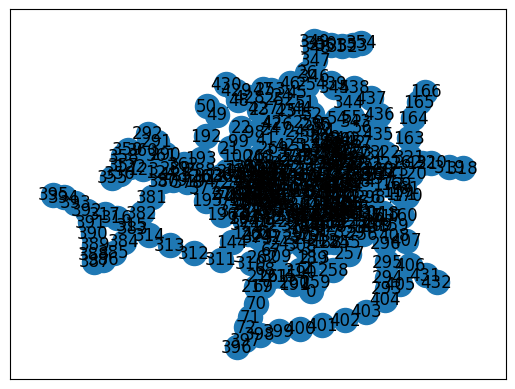

In [25]:
graph = nx.from_numpy_array(stations_matrix, parallel_edges=True)
nx.draw_networkx(graph)

In [26]:
damping_factor=0.85
max_iter=100
pagerank_scores = nx.pagerank(graph, alpha=damping_factor, max_iter=max_iter)
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
top_5_metro_stations_ids = sorted_pagerank[:5]
for id_, v in top_5_metro_stations_ids:
  print(stations_df.index[id_])

tpk_Кунцевская
sokolnicheskaya-linija_Комсомольская
mcd-1_Кунцевская
arbatsko-pokrovskaya-linija_Кунцевская
nekrasovskaya_Косино


# Simrank

In [27]:
def simrank(graph, C=0.8, max_iter=100, tol=1e-4):
  n = len(graph.nodes())
  S_prev = np.identity(n)
  S_next = np.zeros((n, n))

  neighbors = {}
  for node in graph.nodes():
      idx = station_index_map[node]
      neighbors[idx] = [station_index_map[n] for n in graph.neighbors(node)]

  print(f"Запуск SimRank для {n} станций...")
  start_time = time.time()

  for iteration in range(max_iter):
      S_next = np.zeros((n, n))

      for i in range(n):
          for j in range(n):
              if i == j:
                  S_next[i, j] = 1.0
              else:
                  neighbors_i = neighbors[i]
                  neighbors_j = neighbors[j]

                  if len(neighbors_i) == 0 or len(neighbors_j) == 0:
                      S_next[i, j] = 0.0
                  else:
                      total_sim = 0.0
                      for a in neighbors_i:
                          for b in neighbors_j:
                              total_sim += S_prev[a, b]

                      S_next[i, j] = (C / (len(neighbors_i) * len(neighbors_j))) * total_sim

      diff = np.max(np.abs(S_next - S_prev))
      if diff < tol:
          print(f"Сходимость достигнута на итерации {iteration + 1}")
          break

      S_prev = S_next.copy()

      if (iteration + 1) % 10 == 0:
          print(f"Итерация {iteration + 1}, максимальное изменение: {diff:.6f}")

  end_time = time.time()
  print(f"SimRank выполнен за {end_time - start_time:.2f} секунд")

  simrank_matrix = S_next
  return S_next

In [28]:
def find_station_clusters(simrank_matrix, threshold=0.7):

  n = len(station_index_map)
  clusters = []
  visited = set()

  for i in range(n):
      if i not in visited:
          cluster = [index_station_map[i]]
          visited.add(i)

          for j in range(i + 1, n):
              if j not in visited and simrank_matrix[i, j] >= threshold:
                  cluster.append(index_station_map[j])
                  visited.add(j)

          if len(cluster) > 1:
              clusters.append(cluster)

  return clusters

In [29]:
stations = sorted(list(graph.nodes()))
station_index_map = {station: idx for idx, station in enumerate(stations)}
index_station_map = {idx: station for idx, station in enumerate(stations)}

In [30]:
simrank_matrix = simrank(graph)

Запуск SimRank для 442 станций...
Итерация 10, максимальное изменение: 0.003793
Итерация 20, максимальное изменение: 0.000204
Сходимость достигнута на итерации 23
SimRank выполнен за 17.49 секунд


In [31]:
clusters = find_station_clusters(simrank_matrix, threshold=0.001)
print(f"\nНайдено кластеров станций: {len(clusters)}")
for i, cluster in enumerate(clusters[:5]):
  stations_within_cluster = [stations_df.index[id_] for id_ in cluster]
  print(f"Кластер {i} ({len(cluster)} станций): {', '.join(stations_within_cluster)}")


Найдено кластеров станций: 22
Кластер 0 (106 станций): sokolnicheskaya-linija_Бульвар Рокоссовского, sokolnicheskaya-linija_Черкизовская, sokolnicheskaya-linija_Преображенская площадь, sokolnicheskaya-linija_Сокольники, sokolnicheskaya-linija_Красносельская, sokolnicheskaya-linija_Комсомольская, sokolnicheskaya-linija_Красные ворота, sokolnicheskaya-linija_Чистые пруды, sokolnicheskaya-linija_Лубянка, arbatsko-pokrovskaya-linija_Площадь Революции, arbatsko-pokrovskaya-linija_Курская, arbatsko-pokrovskaya-linija_Бауманская, arbatsko-pokrovskaya-linija_Электрозаводская, arbatsko-pokrovskaya-linija_Семеновская, arbatsko-pokrovskaya-linija_Партизанская, arbatsko-pokrovskaya-linija_Измайловская, arbatsko-pokrovskaya-linija_Первомайская, koltsevaya-linija_Таганская, koltsevaya-linija_Курская, koltsevaya-linija_Комсомольская, koltsevaya-linija_Проспект Мира, koltsevaya-linija_Новослободская, kalujsko-rijskaya-linija_Тургеневская, kalujsko-rijskaya-linija_Сухаревская, kalujsko-rijskaya-linija

# Pagerank с CSR-форматом

In [ ]:
for N in [10, 100, 1000]:

  A = np.zeros(shape=(N, N))
  while (A.sum(axis=1) == 0).any():
      A = np.random.randint(0, 2, size=(N, N))
      for i in range(N):
          A[i, i] = 0
          for j in range(i):
              yes = max(A[i, j], A[j, i])
              A[i, j] = A[j, i] = yes
  csr = csr_matrix(A)

  graph = nx.from_numpy_array(A, parallel_edges=True)
  graph_csr = nx.from_scipy_sparse_array(csr, parallel_edges=True)

  print(f'Size = {N}')

  start_time = time.time()
  nx.pagerank(graph, alpha=damping_factor, max_iter=max_iter)
  pagerank_time = time.time() - start_time
  print(f'Standart format pagerank calculation time: {pagerank_time}')

  start_time = time.time()
  nx.pagerank(graph_csr, alpha=damping_factor, max_iter=max_iter)
  pagerank_time = time.time() - start_time
  print(f'CSR format pagerank calculation time: {pagerank_time}\n')

Size = 10
Standart format pagerank calculation time: 0.002429485321044922
CSR format pagerank calculation time: 0.002066373825073242

Size = 100
Standart format pagerank calculation time: 0.010779857635498047
CSR format pagerank calculation time: 0.010022640228271484

Size = 1000
Standart format pagerank calculation time: 0.6905114650726318
CSR format pagerank calculation time: 0.6695210933685303

